In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
#Convert MNIST image files into tensors of 4 dimension (#of images,height,width, colour channel)
transform = transforms.ToTensor()

In [3]:
#train our data
# train_data = datasets.MNIST(root='/cnn_data',train = True,download = True, transform = transform)
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_data.dtype

In [4]:
#test data
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
#loader for data create s mall batch size for images say 10
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [7]:
#Define our CNN model
#Describe conviolutional layer (2 layesrs)
conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

In [8]:
#Grab 1 MNIST record
for i, (X_Train,y_train) in  enumerate(train_data):
    break

In [9]:
X_Train

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [10]:
x = X_Train.view(1,1,28,28) 

In [11]:
#perform first convolution
x = F.relu(conv1(x)) #rectified linear Unit/activation function

In [12]:
#1 single image,6 filters, 26*26 image
x.shape

torch.Size([1, 6, 26, 26])

In [13]:
 #pooling layer 
x = F.max_pool2d(x,2,2) #kernel size of 2 stride of 2

In [14]:
x.shape

torch.Size([1, 6, 13, 13])

In [15]:
#2nd convolutional layer
x = F.relu(conv2(x)) #2nd relu

In [16]:
x.shape #again didn't set padding so we lose 2 pixels around outside of the image

torch.Size([1, 16, 11, 11])

In [17]:
x = F.max_pool2d(x,2,2)

In [18]:
x.shape #11/2 = 5.5 we have to round down so 5 because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [19]:
#Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        #fully connected layer
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10) #10 classes
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        #SECOND PASS
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        #Review to flat it out
        X = X.view(-1,16*5*5) #-1 so that we can vary the batch size

        #fully connected layer
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X) #not doing relu on the last layer
        return F.log_softmax(X, dim = 1)

In [20]:
#create an instance of a model
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [21]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
#Loss function Optimizer
criterion = nn.CrossEntropyLoss()
#smaller the lr longer the training time 
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) 

In [24]:
import time
start_time = time.time()

#create variables to track 
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop for Epochs
for i in range(epochs):
    trn_correct = 0
    tst_correct = 0
    
    #Train
    for b, (X_train,y_train) in enumerate(train_loader):
        b+= 1
        y_pred = model(X_train)# get predicted value form the training set. Not flattened 2D
        loss = criterion(y_pred,y_train) #compare prediction to correct answers

        predicted = torch.max(y_pred.data, 1)[1] #add no of correct predictions
        batch_correct = (predicted == y_train).sum() #how many correct predictions we have
        trn_correct += batch_correct
        
        #Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #results
        if b%600 == 0:
            print(f'Epoch : {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss.item())
    train_correct.append(trn_correct)
    
    #Test
    with torch.no_grad():  #No gradient so we don't update our weights with biases with test
        for b,(X_test,y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] #adding up correct prediction
            tst_correct += (predicted == y_test).sum() #summing 

    loss = criterion(y_val,y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_correct)
            


current_time = time.time()
total_time = current_time - start_time
print(f'Training the data took {total_time/60} minutes!')

Epoch : 0 Batch: 600 Loss: 0.15999142825603485
Epoch : 0 Batch: 1200 Loss: 0.1676756739616394
Epoch : 0 Batch: 1800 Loss: 0.5335274338722229
Epoch : 0 Batch: 2400 Loss: 0.12342406809329987
Epoch : 0 Batch: 3000 Loss: 0.009957398287951946
Epoch : 0 Batch: 3600 Loss: 0.39355140924453735
Epoch : 0 Batch: 4200 Loss: 0.004956956021487713
Epoch : 0 Batch: 4800 Loss: 0.0013879183679819107
Epoch : 0 Batch: 5400 Loss: 0.052941907197237015
Epoch : 0 Batch: 6000 Loss: 0.000414765760069713
Epoch : 1 Batch: 600 Loss: 0.0020838973578065634
Epoch : 1 Batch: 1200 Loss: 0.1946907937526703
Epoch : 1 Batch: 1800 Loss: 0.005659713875502348
Epoch : 1 Batch: 2400 Loss: 0.0023059649392962456
Epoch : 1 Batch: 3000 Loss: 0.03414521366357803
Epoch : 1 Batch: 3600 Loss: 0.6318167448043823
Epoch : 1 Batch: 4200 Loss: 0.0171750970184803
Epoch : 1 Batch: 4800 Loss: 0.00048171007074415684
Epoch : 1 Batch: 5400 Loss: 0.0005679561290889978
Epoch : 1 Batch: 6000 Loss: 0.22635331749916077
Epoch : 2 Batch: 600 Loss: 0.07

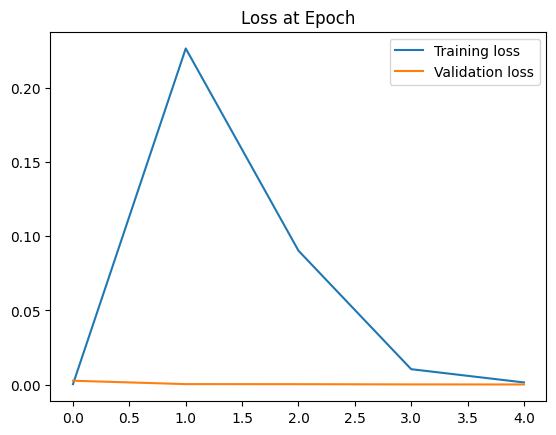

In [27]:
#Graph the loss in epochs
# train_losses = [ tl.item() for tl in train_losses]
plt.plot(train_losses, label ="Training loss")
plt.plot(test_losses, label ="Validation loss")
plt.title("Loss at Epoch")
plt.legend()

Text(0.5, 1.0, 'Accuracy at the end of each Epoch')

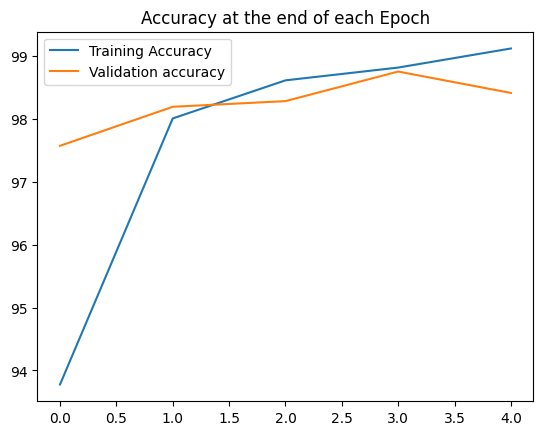

In [29]:
#graph the accuracy at each epoch
plt.plot([t/600 for t in train_correct ], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation accuracy")
plt.legend()
plt.title("Accuracy at the end of each Epoch")

In [30]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [32]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [34]:
#Did for coorrect
correct.item()/len(test_data)*100

98.41

In [37]:
#Grab an image
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [38]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [39]:
#reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

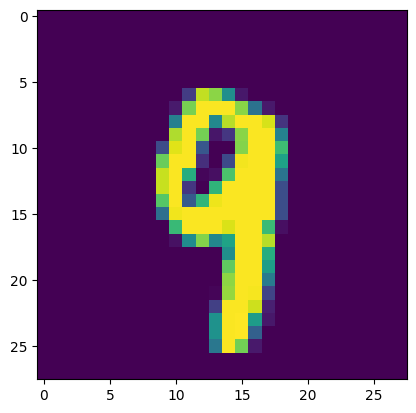

In [41]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [42]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1,1,28,28))

In [44]:
new_prediction

tensor([[-2.6490e+01, -2.1835e+01, -2.3541e+01, -1.6834e+01, -1.1299e+01,
         -2.2324e+01, -3.7313e+01, -1.3830e+01, -1.5755e+01, -1.3471e-05]])

In [45]:
new_prediction.argmax()

tensor(9)